# 0.0. Imports

In [1]:
# data manipulation
import numpy as np 
import pandas as pd
import datetime

# text
import inflection

# math
import math

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# image
from IPython.display import Image

# statistic
import scipy.stats as ss

# pre-pŕocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
# notebook settings
def notebook_settings():
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 10

# calculate Cramers V statistic for categorial-categorial association
def cramers_v(x, y):
    # Calculate confusion matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    # Calculate chi2
    chi2 = ss.chi2_contingency(cm)[0]
    # Calculate chi2 correction
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    # K correction
    kcorr = k - (k-1)**2/(n-1)
    # R correction
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [3]:
notebook_settings()

## 0.2. Loading Data

In [4]:
# using pandas to read csv files
rossman_raw_train = pd.read_csv('../data/train.csv', parse_dates=['Date'], low_memory=False) # parse_data change object to datetime
rossman_raw_store = pd.read_csv('../data/store.csv', low_memory=False)

# merge train and store dataset
df_raw = pd.merge(rossman_raw_train, rossman_raw_store, how='left', on ='Store')

# 1.0. Data Description

In [5]:
# copy for section 1.0
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# list of columns name
col_old = df1.columns

# loop for snakecase pattern
snakecase = lambda x: inflection.underscore(x)

# setting list for new columns 
col_new = list(map(snakecase, col_old))

# change names
df1.columns = col_new

## 1.2. Data Dimension

In [7]:
# show information about data dimension
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209 
Number of columns: 18


## 1.3. Data Type

In [8]:
# checking data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking Null Values

In [9]:
# checking missing values
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout Null Values

### 1.5.a competition_distance

Null Values will represent a big distance from other stores, something bigger than max value presents in data.

In [10]:
# fill null values
df1.competition_distance = df1.competition_distance.fillna(200000)

### 1.5.b competition_open_since_month

Using `date` column to fill out the null value

In [11]:
# competition open since month function 
comp_open_month = lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) \
    else x['competition_open_since_month']

df1['competition_open_since_month'] = df1.apply(comp_open_month, axis=1)

### 1.5.c competition_open_since_year

Same idea for the previous section

In [12]:
# competition open since year function 
comp_open_year = lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) \
    else x['competition_open_since_year']

df1['competition_open_since_year'] = df1.apply(comp_open_year, axis=1)

### 1.5.d promo2_since_week

Using the same logic from the previous section

In [13]:
promo2_sw = lambda x: x['date'].week if math.isnan(x['promo2_since_week']) \
    else x['promo2_since_week']

df1['promo2_since_week'] = df1.apply(promo2_sw, axis=1)

### 1.5.e promo2_since_year

Using the same logic from the previous section

In [14]:
promo2_sy = lambda x: x['date'].year if math.isnan(x['promo2_since_year']) \
    else x['promo2_since_year']

df1['promo2_since_year'] = df1.apply(promo2_sy, axis=1)

### 1.5.f promo_interval

If date column is inside the promo column, then let's say it was a promoted day.

In [15]:
# list with months names
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# list with number sequence
number_seq = np.arange(1,13).tolist()

# converting two lists into a dictionary
promo_month = dict(zip(number_seq, month_list))

# converting null values into 0
df1['promo_interval'].fillna(0, inplace=True)

# Coluns with month names
df1['month_map'] = df1['date'].dt.month.map(promo_month)

# function to detect promo times
is_promo_function = lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map']\
     in x['promo_interval'].split(',') else 0

# new column to promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    is_promo_function, axis=1)

In [16]:
# checking NaN again
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [17]:
# checking types again
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
# list of columns who need to change type
change_type = [
    'competition_open_since_month', 'competition_open_since_year',
    'promo2_since_week', 'promo2_since_year'
    ]

# looping change type
for x in change_type:
    df1[x] = df1[x].astype(int)

## 1.7. Descriptive Statistical

Selecting variables by type, numerical and categorical

In [19]:
# selecting features by types
num_att = df1.select_dtypes(include=['int64', 'float64']) # selecting numerical features
cat_att = df1.select_dtypes(include=['object']) # selecting objects and datetime features

### 1.7.a Numerical Attributes

In [20]:
# describe function into variable
descriptive_1 = num_att.describe().T.reset_index()

# add range
descriptive_1['range'] = (num_att.max() - num_att.min()).tolist()
# add skew
descriptive_1['skew'] = num_att.skew().tolist()
# add kurtosis
descriptive_1['kurtosis'] = num_att.kurtosis().tolist()

In [21]:
# checking
descriptive_1

,index,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,6.0,0.001593,-1.246873
2,sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,0.641460,1.778375
3,customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7388.0,1.598650,7.091773
4,open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
5,promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.235657,124.071304


#### > Skew

In [22]:
# creating list with skew classification
symmetrical = []
mod_skew = []
high_skew = []

# iterate 
for i in range(len(descriptive_1)):
    if descriptive_1.iloc[i, -2] > 1 or descriptive_1.iloc[i, -2] < -1:
        high_skew.append(descriptive_1.iloc[i, 0])
    elif 1 >= descriptive_1.iloc[i, -2] > 0.5:
        mod_skew.append(descriptive_1.iloc[i, 0])
    elif -0.5 > descriptive_1.iloc[i, -2] >= -1:
        mod_skew.append(descriptive_1.iloc[i, 0])
    else:
        symmetrical.append(descriptive_1.iloc[i, 0])

# print
print(symmetrical)
print(mod_skew)
print(high_skew)        

['store', 'day_of_week', 'promo', 'competition_open_since_month', 'promo2', 'promo2_since_week']
['sales', 'promo2_since_year']
['customers', 'open', 'school_holiday', 'competition_distance', 'competition_open_since_year', 'is_promo']


#### > Kurtosis

In [23]:
# creating list with skew classification
leptokurtic = []
mesokurtic = []
platykurtic = []

# iterate 
for i in range(len(descriptive_1)):
    if descriptive_1.iloc[i,-1] > 3:
        leptokurtic.append(descriptive_1.iloc[i, 0])
    elif descriptive_1.iloc[i,-1] == 3:
        mesokurtic.append(descriptive_1.iloc[i, 0])
    else:
        platykurtic.append(descriptive_1.iloc[i, 0])

# print
print(leptokurtic)
print(mesokurtic)
print(platykurtic)  

['customers', 'competition_distance', 'competition_open_since_year']
[]
['store', 'day_of_week', 'sales', 'open', 'promo', 'school_holiday', 'competition_open_since_month', 'promo2', 'promo2_since_week', 'promo2_since_year', 'is_promo']


### 1.7.b. Categorical Attributes

In [24]:
# checking unique attributes for categorical
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

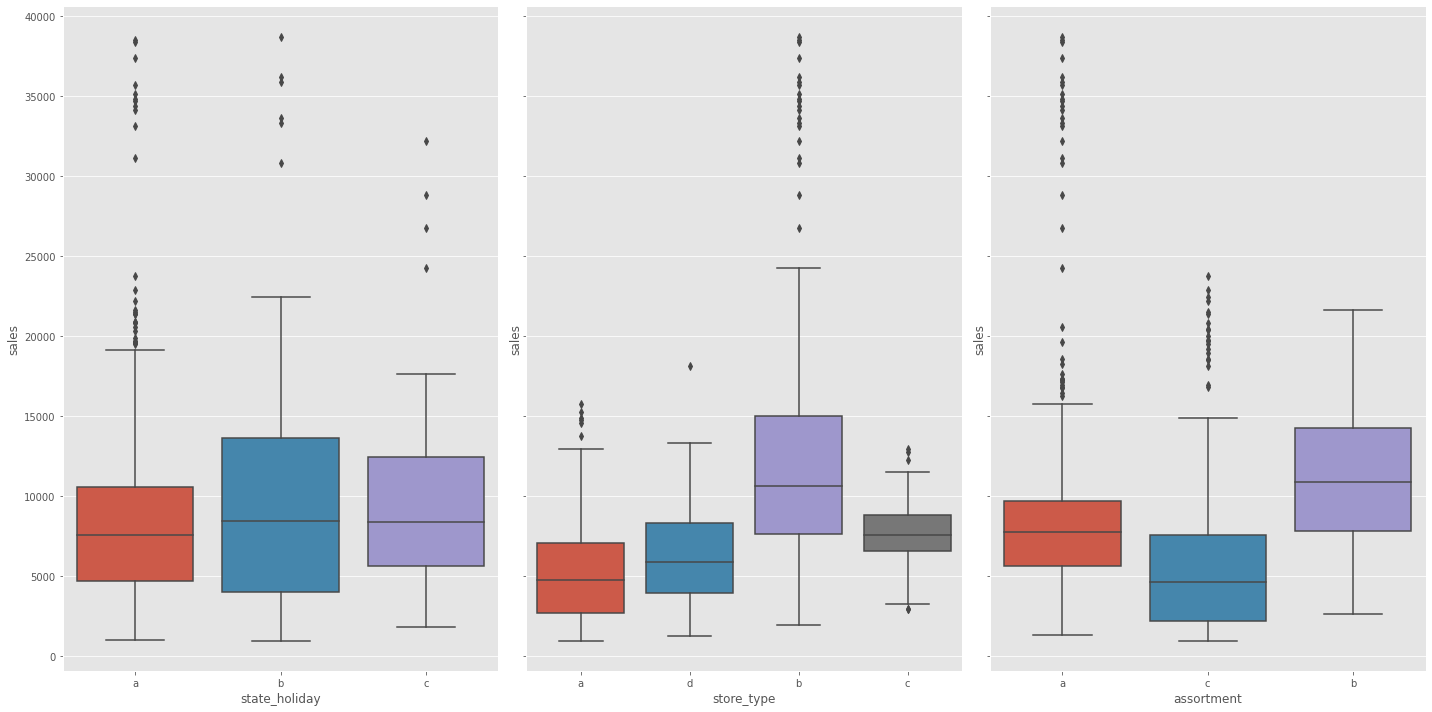

In [25]:
# filtering state_holiday without sales and promo
no_sales = df1[(df1.state_holiday != '0') & (df1.sales > 0)]

# violintplot to categorical attributes
fig, ax = plt.subplots(1, 3, sharey=True)
# state holiday
sns.boxplot(data=no_sales, x='state_holiday', y='sales', ax=ax[0])
# store type
sns.boxplot(data=no_sales, x='store_type', y='sales', ax=ax[1])
# assortment
sns.boxplot(data=no_sales, x='assortment', y='sales', ax=ax[2])

# adjust plot
plt.tight_layout()
# show plot
plt.show()

# 2.0. Feature Engineering

## 2.1. Hypothesis Mind Map

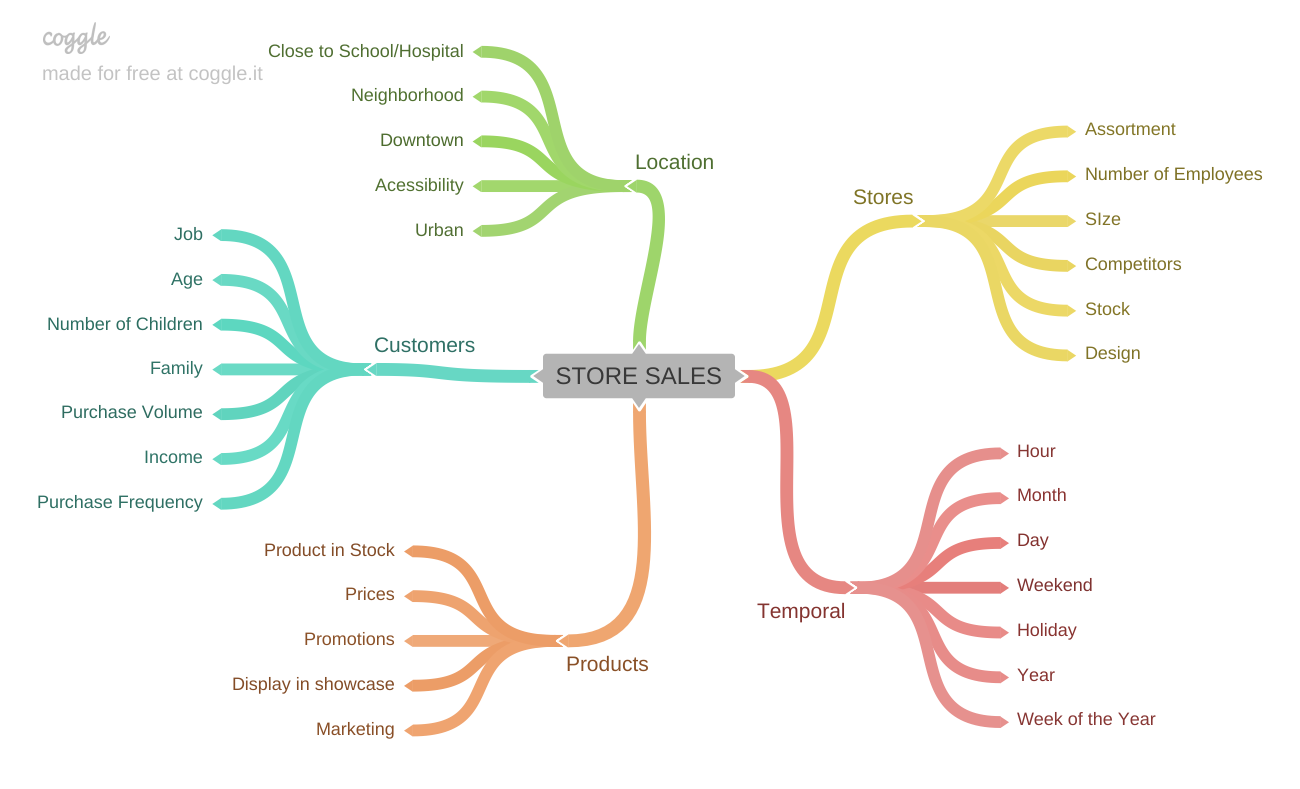

In [26]:
Image('../img/STORE_SALES.png')

## 2.2. Hypothesis Creation

### 2.2.a. Store

**1.** Stores with a larger workforce should sell more.

**2.** Stores with higher inventory should sell more.

**3.** Larger store should sell more.

**4.** Smaller Stores should sell more.

**5.** Stores with a larger assortment should sell more.

**6.** Stores with closer competitors should sell less.

**7.** Stores with longer competitors should sell more

### 2.2.b. Product

**1.** Stoers that invest more in marketing should sell more.

**2.** Stores that display more products in a showcase sell more.

**3.** Stores with smaller prices should sell more.

**4.** Stores that keep prices lower for longer should sell more.

**5.** Stores with active promotions for longer should sell more.

**6.** Stores with more promotion days should sell more.

### 2.2.c. Time

**1.** Stores should sell less on weekends.

**2.** Stores that open in the first 6 months should sell more.

**3.** Stores that open on weekends should sell more.

**4.** Stores open during the Christmas holiday should sell more.

**5.** Stores should be selling more over the years.

**6.** Stores should sell more in the second half of the year.

**7.** Stores should sell more after the 10th of each month.

**8.** Stores should sell less on weekends.

**9.** Stores should sell less during school holidays.

## 2.3. Final Hypothesis List

**01.** Stores with a larger assortment should sell more.

**02.** Stores with closer competitors should sell less.

**03.** Stores with longer competitors should sell more

**04.** Stores with active promotions for longer should sell more.

**05.** Stores with more promotion days should sell more.

**06.** Stores with more consecutive promotions should sell more.

**07.** Stores open during the Christmas holiday should sell more.

**08.** Stores should be selling more over the years.

**09.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4. Feature Enginneering

In [27]:
df2 = df1.copy()

### 2.4.a. Time

In [28]:
# year
df2['year'] = df2.date.dt.year

# month
df2['month'] = df2.date.dt.month

# day 
df2['day'] = df2.date.dt.day

# week of year
df2['week_of_year'] = df2.date.dt.isocalendar().week

# year week
df2['year_week'] = df2.date.dt.strftime('%Y-%W')

### 2.4.b. Competition and Promo

In [29]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],\
     month=x['competition_open_since_month'], day=1), axis=1)

# competition time month column
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))

# time of promotion
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

### 2.4.c. Assortment and Holidays

In [30]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public holiday' if x == 'a' else 'easter holiday' \
        if x == 'b' else 'christmas'\
             if x == 'c' else 'regular day')

# 3.0. Filtering Variables

In [31]:
df3 = df2.copy()

## 3.1. Row Filtering

In [32]:
# closed stores has no sales in that day.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [33]:
# selecting columns to drop
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drop columns
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Exploratory Data Analysis

In [34]:
# copy for EDA
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.a. Target Variable

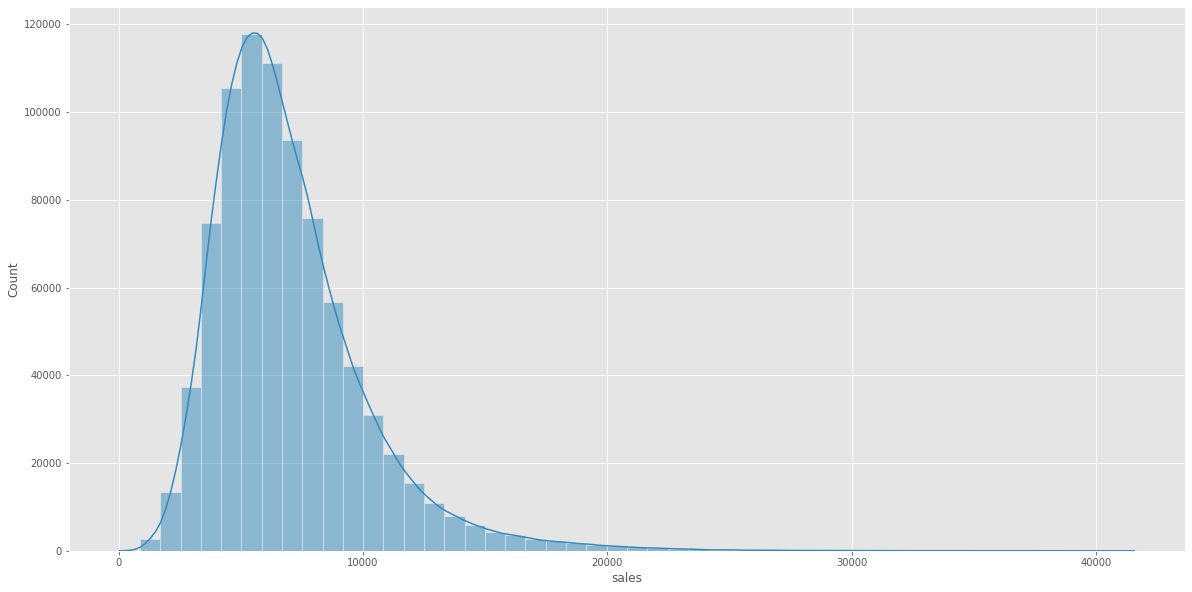

In [35]:
#fig, ax = plt.subplots(2,1)
# checking density of target variable
sns.histplot(df4.sales, kde=True, bins = 50)
# plot boxplot
#ax[1].boxplot(df4.sales, vert=False)
# show plot
#plt.savefig('../img/img02.png')
plt.show()

### 4.1.b.Numerical Variable

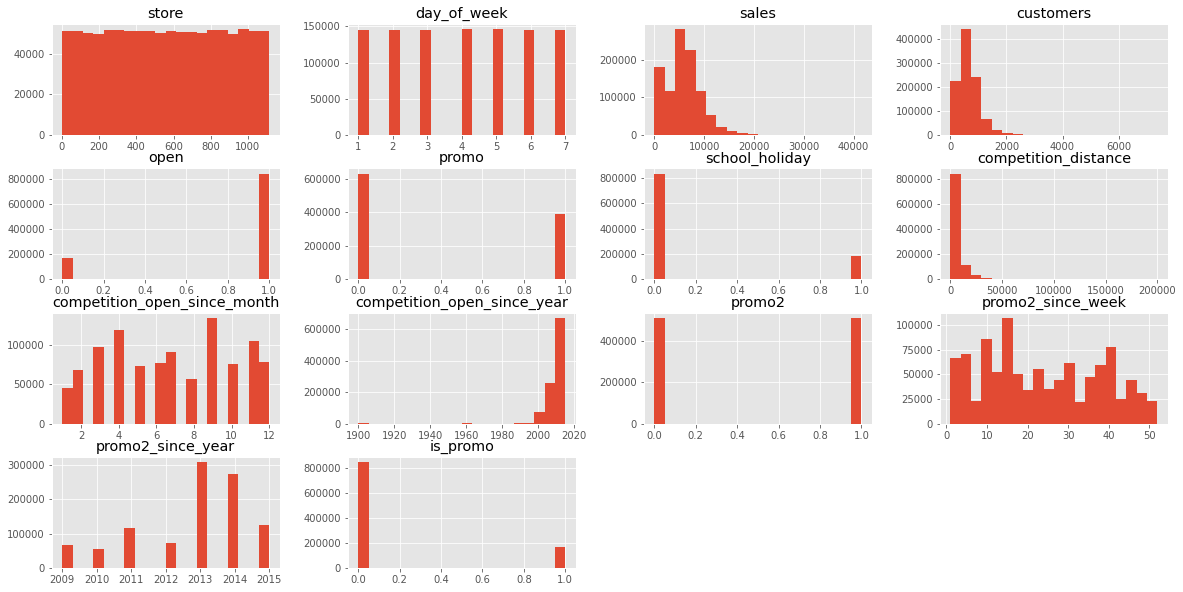

In [36]:
# checking numerical variables
num_att.hist(bins=20);

Some observations:
* `customers` - higher sales when the customer range is between 0 and 2000.
* `competition distance` - grand part of competitors are very close.
* `competition_open_since_month` - most of competitors are concentrated at beginning and end of the year, November has the highest concentration. 
* `competition_open_since_year` - between 2010 and 2015 had the biggest increase in competitors.
* `is_promo` - there is more sales when don't have promotion.

### 4.1.c. Categorical Variable

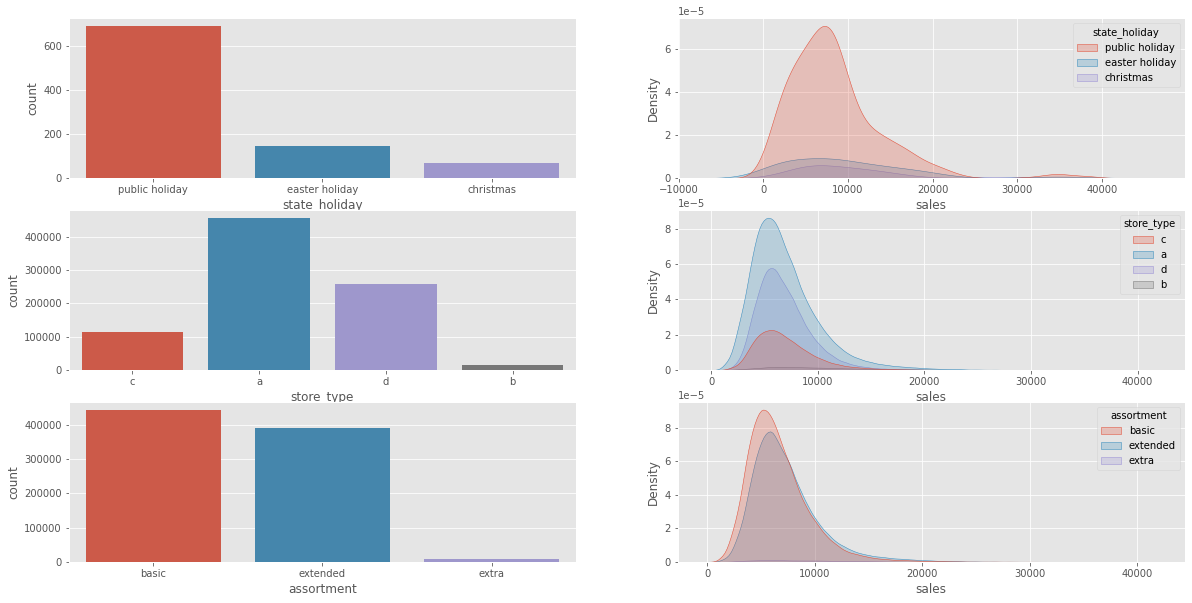

In [37]:
# removing regular day to a better visualize
no_rd = df4.query('state_holiday != "regular day"')

# setting fig and axes
fig, ax = plt.subplots(3,2)
# subplot 1
sns.countplot(x=no_rd['state_holiday'], ax=ax[0,0])
# subplot 2
sns.kdeplot(data=no_rd, x='sales', hue= 'state_holiday', shade=True, ax=ax[0,1])
# subplot 3
sns.countplot(x=df4['store_type'], ax=ax[1,0])
# subplot 4
sns.kdeplot(data=df4, x='sales', hue='store_type', shade=True, ax=ax[1,1])
# subplot 5
sns.countplot(x=df4['assortment'], ax=ax[2,0])
# subplot 6
sns.kdeplot(data=df4, x='sales', hue='assortment', shade=True, ax=ax[2,1])
# plot show
plt.show()

## 4.2. Bivariate Analysis 

### H1. Stores with a larger assortment should sell more.
*FALSE* - Stores with larger assortment sell less.

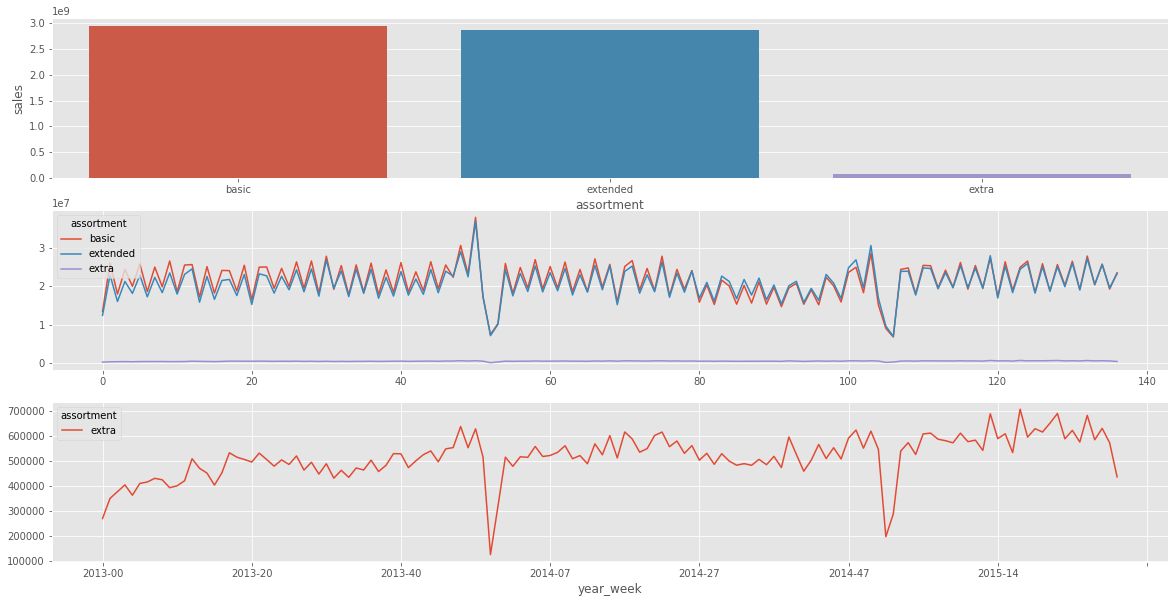

In [38]:
# grouping assortment 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# grouping by year weeek and assortment
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment'])\
    .sum().reset_index()
# pivot dataframe
pv_aux2 = aux2.pivot(index='year_week', columns='assortment', values='sales').\
    reset_index()
# checking assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
pv_aux3 = aux3.pivot(index='year_week', columns='assortment', values='sales')

# setting fig and axes
fig, ax = plt.subplots(3,1)
# subplot 1
sns.barplot(data=aux1, x='assortment', y='sales', ax=ax[0])
# subplot 2
pv_aux2.plot(ax=ax[1])
# subplot 3
pv_aux3.plot(ax=ax[2])
# show plot
plt.show()

### H2. Stores with closer competitors should sell less.
*FALSE*: Store with closer competitor sell more.

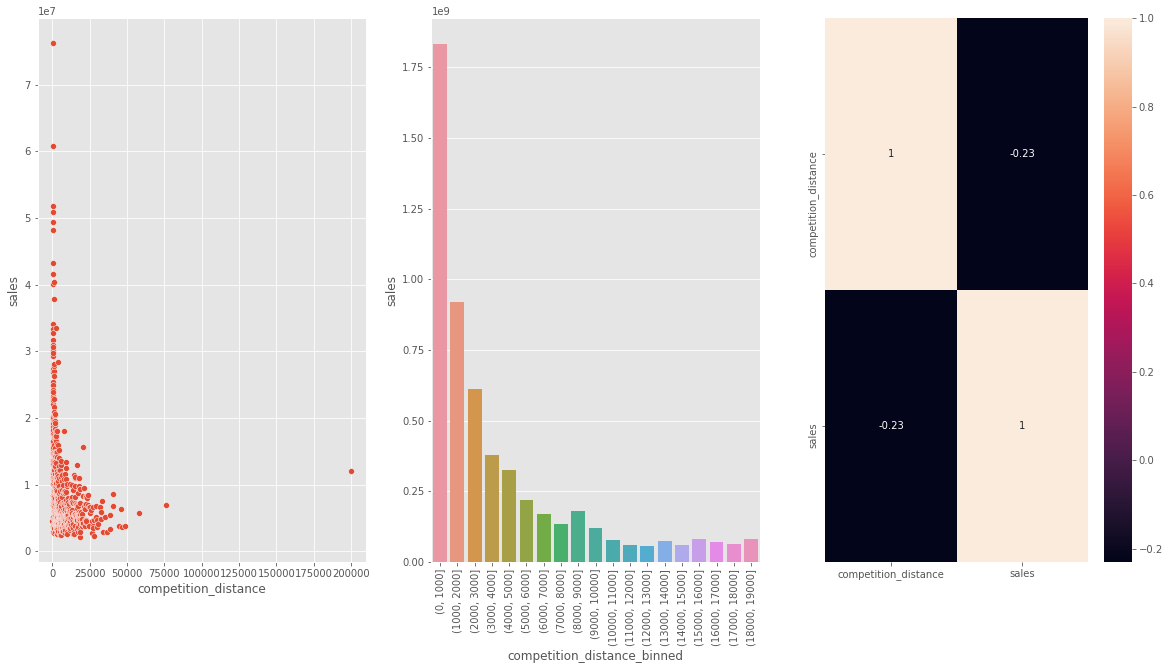

In [39]:
# groupby competition distance
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().\
    reset_index()
# split by bins
bins = list(np.arange(0, 20000, 1000))
# cuting intervals by bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# groupby competitiondistance binned
aux2 = aux1[['competition_distance_binned', 'sales']]\
    .groupby('competition_distance_binned').sum().reset_index()

fig, ax = plt.subplots(1,3)
# subplot 1
sns.scatterplot(data=aux1, x='competition_distance', y='sales', ax=ax[0])
# subplot 2
sns.barplot(data=aux2, x='competition_distance_binned', y='sales', ax=ax[1])
ax[1].set_xticklabels(aux2.competition_distance_binned, rotation=90)
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
plt.show()

### H3. Stores with longer competitors should sell more.
*FALSE*: Store with longer competitor sell less.

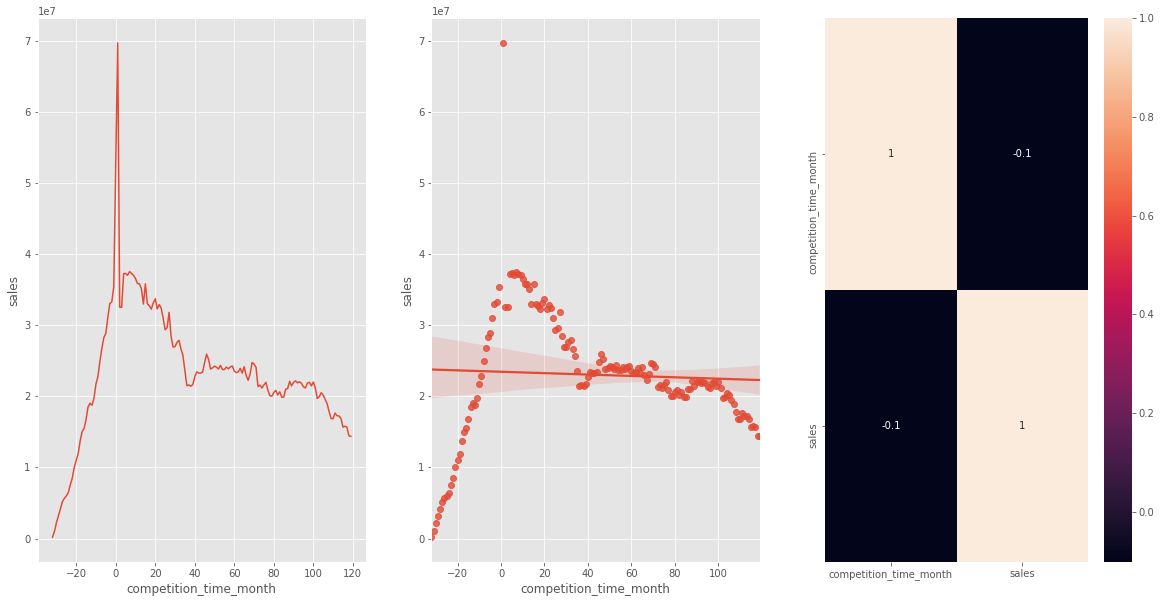

In [40]:
# groupby competition time month
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# filtering competition time month
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]

# setting fig and axes
fig, ax = plt.subplots(1,3)
# subplot 1
sns.lineplot(data=aux2, x='competition_time_month', y='sales', ax=ax[0])
# subplot 2
sns.regplot(data=aux2, x='competition_time_month', y='sales', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
# plot fig
plt.show()

### H4. Stores with active promotions for longer should sell more.
*FALSE*: Stores with active promotion for longer sell less, after a period of time.

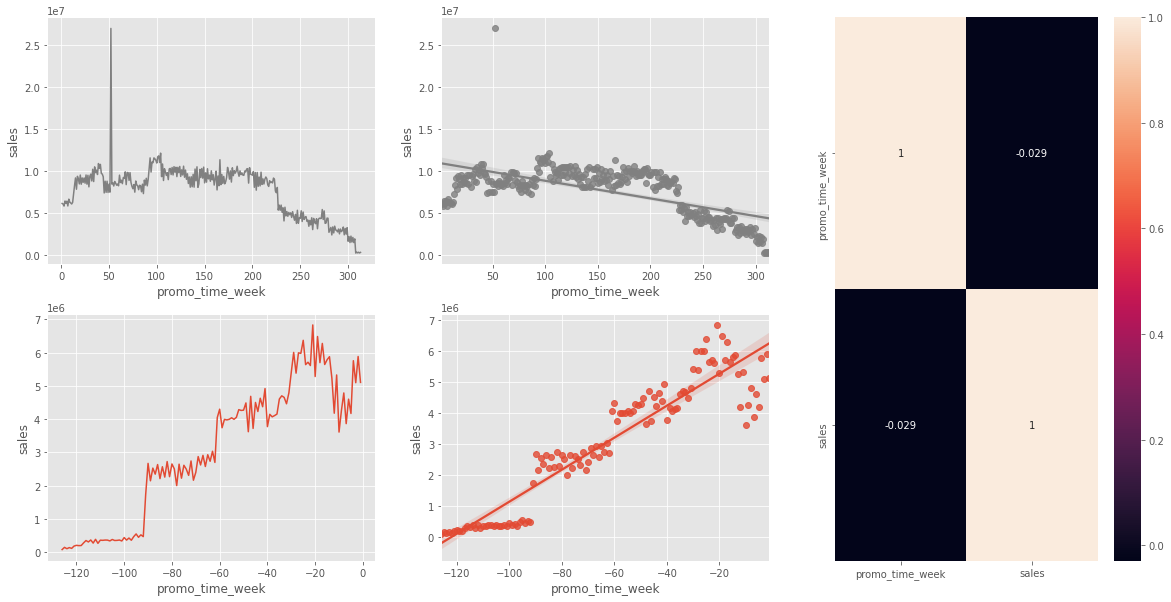

In [41]:
# groupinb promo time week
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# extended promo
aux2 = aux1[aux1['promo_time_week'] > 0]
# regular promo
aux3 = aux1[aux1['promo_time_week'] < 0]

# grid spec
gs = gridspec.GridSpec(2, 3)

# subplot for extended
plt.subplot(gs[0,0])
sns.lineplot(data=aux2, x='promo_time_week', y='sales', color='gray')
plt.subplot(gs[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales', color='gray')
# subplot for regular
plt.subplot(gs[1,0])
sns.lineplot(data=aux3, x='promo_time_week', y='sales')
plt.subplot(gs[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')
# heatmap
plt.subplot(gs[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)
# plot show
plt.show()

### <s> H5. Stores with more promotion days should sell more.</s>

In [42]:
# it'll be validated in the second CRISP cycle.

### H6. Stores with more consecutive promotions should sell more.
*False*: Stores with more consecutive promotions sell less.

In [43]:
# checking sales in promo period strategy
promo = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
promo.sort_values(by='sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


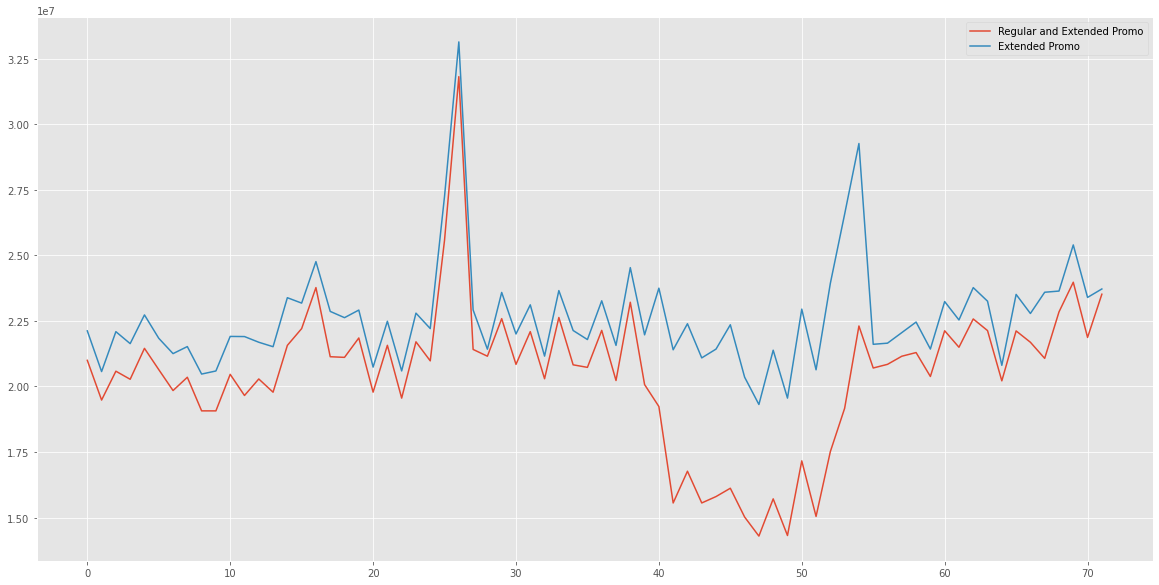

In [44]:
# participate in promo and extended promo
aux1 = df4.query('promo == 1 & promo2 == 1')[['year_week', 'sales']].groupby('year_week').sum().reset_index()
# participate in promo and not in extended promo
aux2 = df4.query('promo == 1 & promo2 == 0')[['year_week', 'sales']].groupby('year_week').sum().reset_index()

# plot
ax = aux1.plot()
aux2.plot(ax=ax)
ax.legend(labels=['Regular and Extended Promo', 'Extended Promo'])
plt.show()

### H7. Stores open during the Christmas holiday should sell more.
*False*: Stores open during the Christmas holiday sell less.

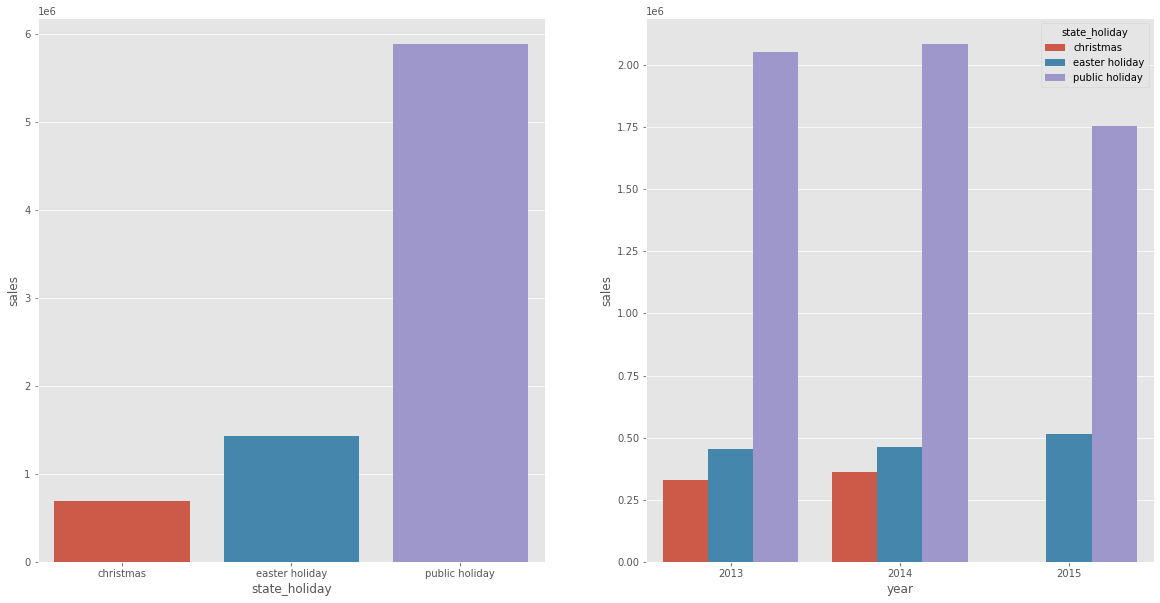

In [45]:
# removing regular days
aux = df4[df4.state_holiday != 'regular day']
# grouping state holidays
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
# grouping holidays by year
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,2)
# subplot 1
sns.barplot(data=aux1, x='state_holiday', y='sales', ax=ax[0])
# subplot 2
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday', ax=ax[1])
# plot show
plt.show()

### H8. Stores should be selling more over the years.
*False*: Store sell less over the years.

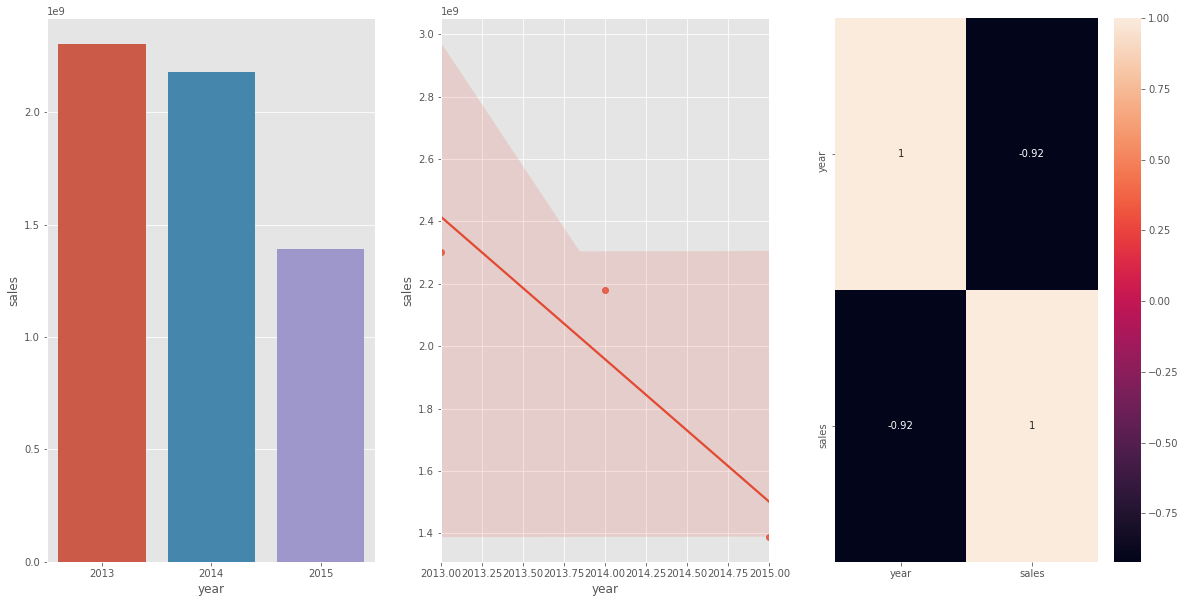

In [46]:
# grouping sales by year
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,3)
# subplot 1
sns.barplot(data=aux1, x='year', y='sales', ax=ax[0])
# subplot 2
sns.regplot(data=aux1, x='year', y='sales', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
# plot show
plt.show()

### H9. Stores should sell more in the second half of the year.
*False*: Store sell less in second half of the year.

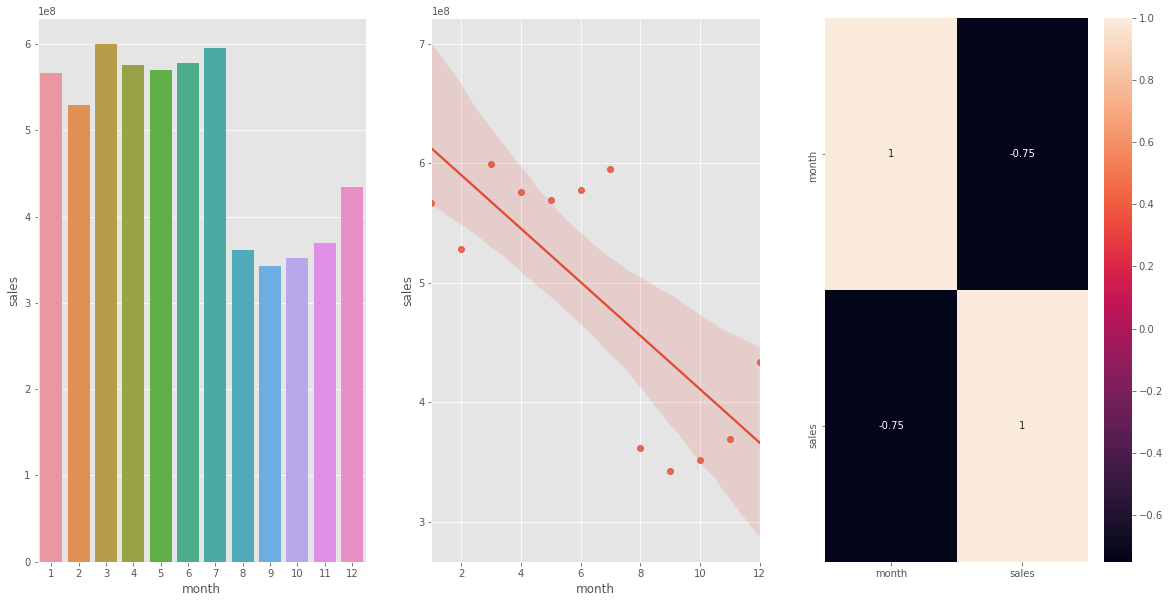

In [47]:
# grouping sales by month
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,3)
# subplot 1
sns.barplot(data=aux1, x='month', y='sales', ax=ax[0])
# subplot 2
sns.regplot(data=aux1, x='month', y='sales', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
# plot show
plt.show()

### H10. Stores should sell more after the 10th of each month.
*True*: Store sell more after the 10th of each month

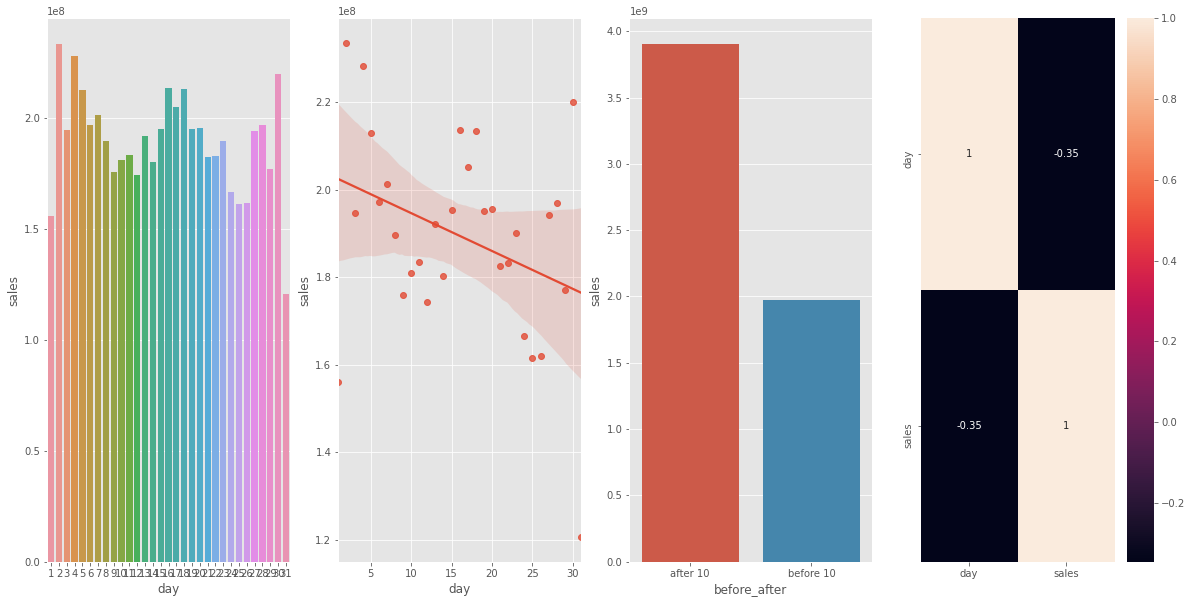

In [48]:
# grouping sales by day
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before 10' if x <= 10 else 'after 10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,4)
# subplot 1
sns.barplot(data=aux1, x='day', y='sales', ax=ax[0])
# subplot 2
sns.regplot(data=aux1, x='day', y='sales', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[3])
# subplot 4
sns.barplot(data=aux2, x='before_after', y='sales', ax=ax[2])
# plot show
plt.show()

### H11. Stores should sell less on weekends.
*True*: Store sell less on weekends.

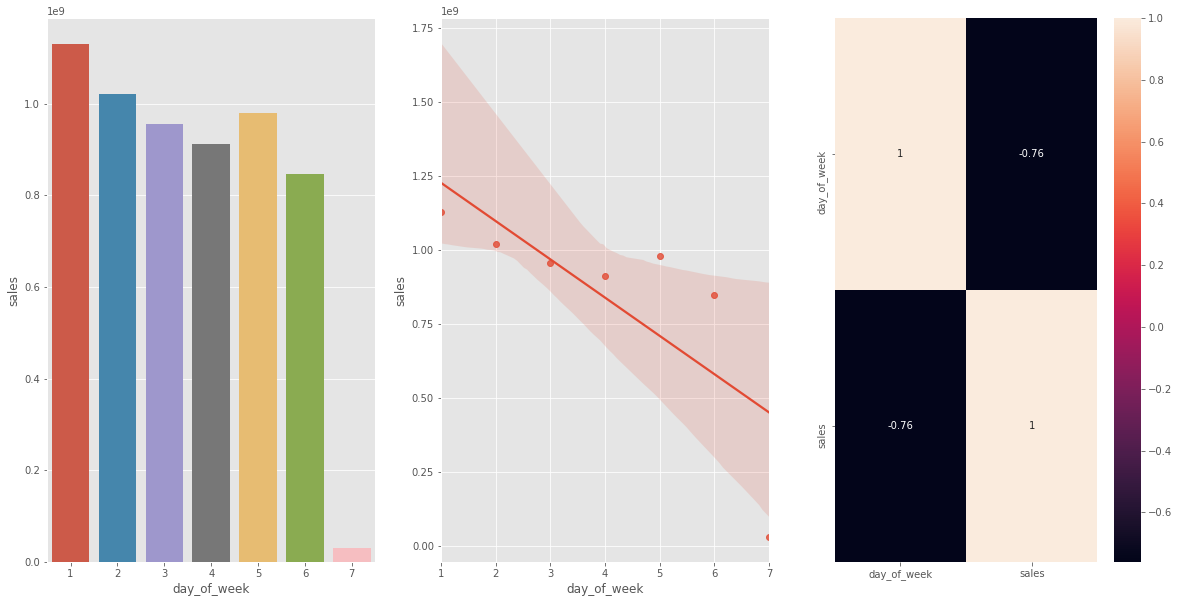

In [49]:
# grouping sales by day of week
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,3)
# subplot 1
sns.barplot(data=aux1, x='day_of_week', y='sales', ax=ax[0])
# subplot 2
sns.regplot(data=aux1, x='day_of_week', y='sales', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
# plot show
plt.show()

### H12. Stores should sell less during school holidays.
*True*: Stores sell less during school holidays.

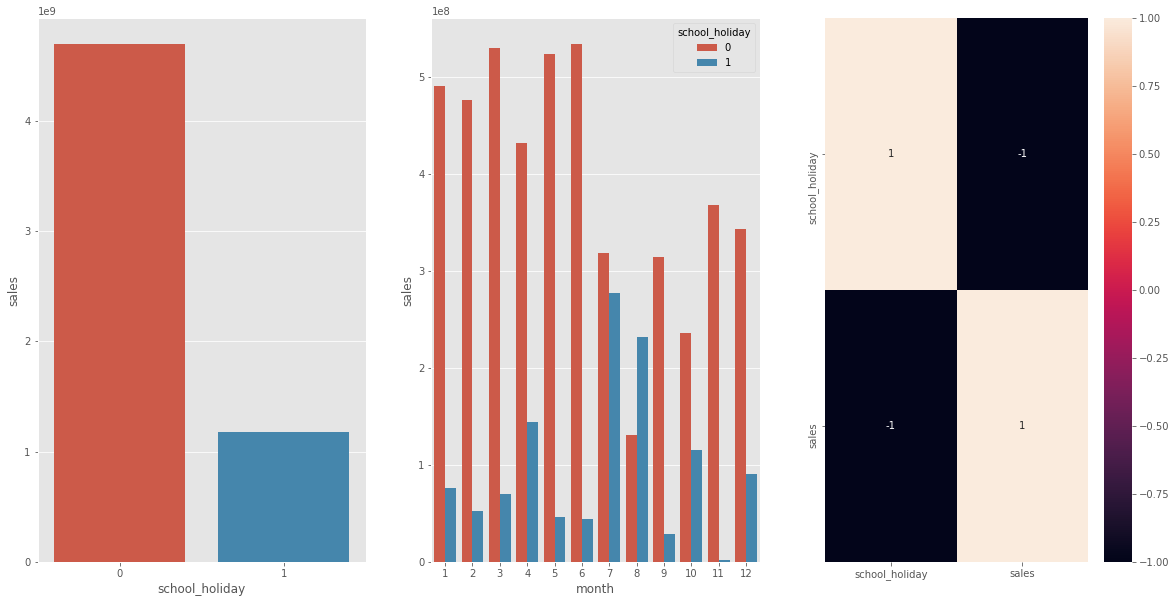

In [50]:
# grouping sales by school holidays
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
# include month
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# fig and axes
fig, ax = plt.subplots(1,3)
# subplot 1
sns.barplot(data=aux1, x='school_holiday', y='sales', ax=ax[0])
# subplot 2
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday', ax=ax[1])
# subplot 3
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])
# plot show
plt.show()

### List Hypothesis

| Nº   | Hypothesis                                                 | Conclusion    |
| ---- | ---------------------------------------------------------- | ------------- |
| H1   | Stores with a larger assortment should sell more.          | False         |
| H2   | Stores with closer competitors should sell less.           | False         |
| H3   | Stores with longer competitors should sell more.           | False         |
| H4   | Stores with active promotions for longer should sell more. | False         |
| H5   | Stores with more promotion days should sell more.          | No conclusion |
| H6   | Stores with more consecutive promotions should sell more.  | False         |
| H7   | Stores open during the Christmas holiday should sell more. | False         |
| H8   | Stores should be selling more over the years.              | False         |
| H9   | Stores should sell more in the second half of the year.    | False         |
| H10  | Stores should sell more after the 10th of each month.      | True          |
| H11  | Stores should sell less on weekends.                       | True          |
| H12  | Stores should sell less during school holidays.            | True          |

## 4.3. Multivariate Analysis

### 4.3.a. Numerical Attributes

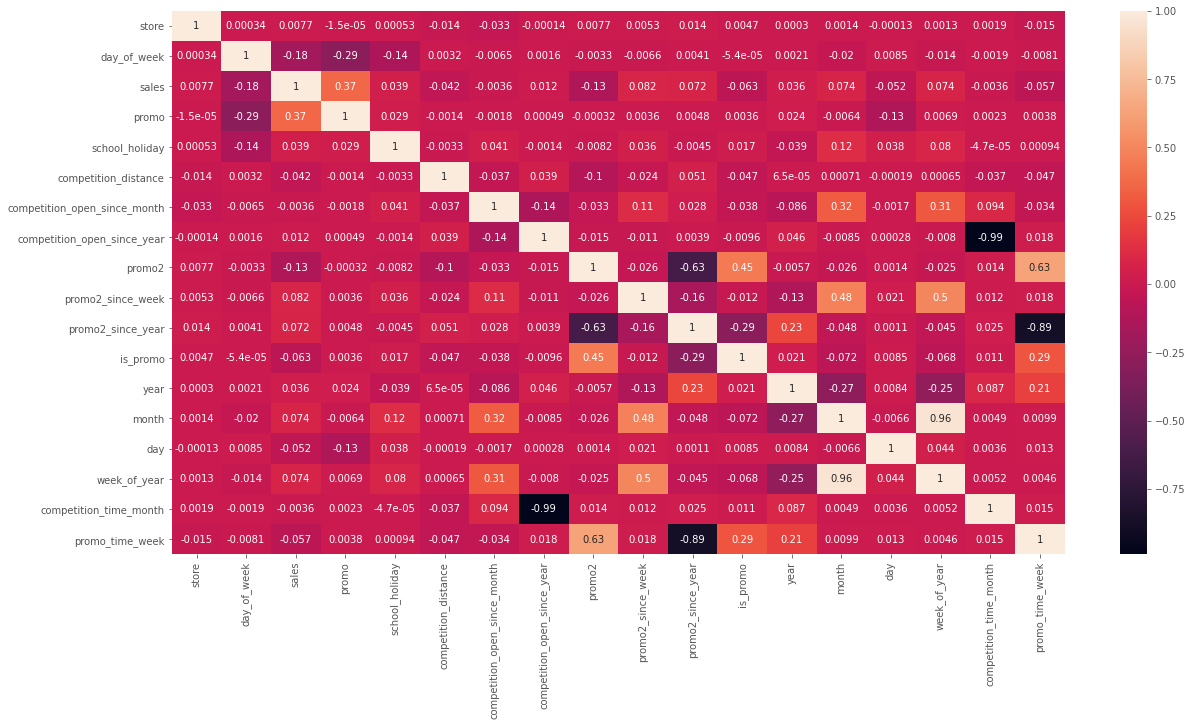

In [51]:
# update numerical attributes with new features
num_att2 = df4.select_dtypes(exclude=['object', 'datetime64[ns]'])
# correlation
correlation = num_att2.corr(method='pearson')
# heatmap
sns.heatmap(correlation, annot=True)
# show plot
plt.show()

### 4.3.b. Categorical Attributes

In [52]:
# update categorical attributes with new features
cat_att2 = df4.select_dtypes(include='object')

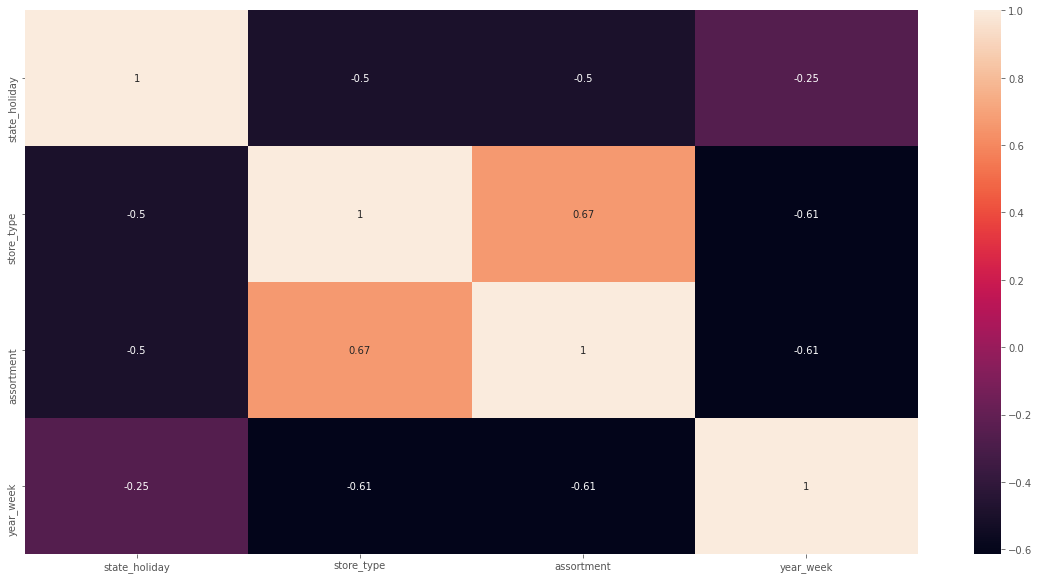

In [53]:
# empty dictionaries
corr_dict = {}

# itarate categorical features
for x in cat_att2.columns.to_list():
    corr_dict[x] = {}

    for y in cat_att2.columns.to_list():
        corr_dict[x][y] = cramers_v(cat_att2[x], cat_att2[y])

# creating dataframe
corr_cat = pd.DataFrame(corr_dict)

# ploting heatmap with categorical features
sns.heatmap(corr_cat.corr(method='pearson'), annot=True);

# 5.0. Data Preparation

In [54]:
df5 = df4.copy()

## 5.1. Normalize

I won't normalize because there's no evidence of gaussian distribution (checking 4.1.b section).

## 5.2. Rescaling

In [55]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [56]:
# instance robust scaler
rs = RobustScaler()
# instance min max scaler
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


## 5.3. Transformation

### 5.3.a. Enconding

In [57]:
# state holiday - one hot enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [60]:
# store type - label enconding
le = LabelEncoder()
df5.store_type = le.fit_transform(df5.store_type)

In [61]:
# assortment - ordinal enconding
assortment_dict = {
    'basic' : 1,
    'extra': 2,
    'extended' : 3
}
df5.assortment = df5.assortment.map(assortment_dict)

### 5.3.b. Response Variable Transformation

In [ ]:
# sales - log transformation
df5['sales'] = np.log1p(df5.sales)

### 5.3.c. Nature Transformation

In [65]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0. Feature Selection